In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
import pickle
from tqdm import tqdm

from utils import FEATURES_DIR, RESULTS_DIR
from analyses.ridge_regression_decoding_mni_mmda import NUM_CV_SPLITS, REGRESSION_MODEL_PYTORCH, REGRESSION_MODEL_SKLEARN, HyperParameters, DISTANCE_METRICS, GLM_OUT_DIR
from notebook_utils import load_results_data

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_mode = "train"
regression_models = [REGRESSION_MODEL_SKLEARN]
distance_metrics = ["cosine", "euclidean"]
subjects = ['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-07']
# subjects = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07']

all_data = load_results_data(training_mode, regression_models, distance_metrics, subjects)

# Filter out PCA'd models
all_data = all_data[~all_data.model.str.contains("PCA")]

In [8]:
def plot_test_metrics(data, distance_metric = 'cosine'):
    metrics = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images', 'rsa']
    data_filtered = data[data.metric.isin(metrics)]
    # data_filtered = data

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind="bar", x="subject", y="value", col="metric", height=4, aspect=1, hue="model")#, palette="Set3"
    g._legend.remove()
    g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9)) # ,ncol=2

    g.set(ylim=(0.8, 0.9))
    
    plt.suptitle("Test Performance", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "model_comparison.png"), dpi=300)


sklearn_alpha=100000.0_full_train_best_val_acc


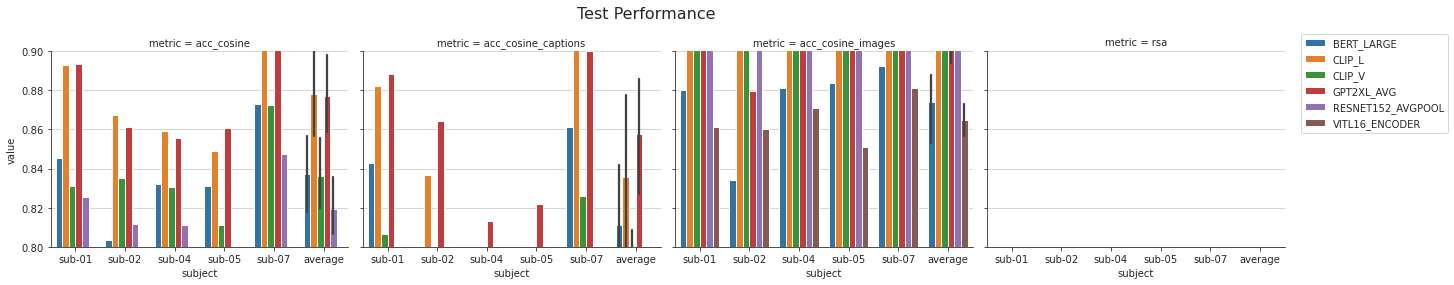

In [9]:
data_to_plot = all_data

# data_to_plot = data_to_plot[~data_to_plot.hp_str.str.contains("[loss:cosine_distance]")]
# print(data_to_plot.hp_str.str.contains("[loss:cosine_distance]"))

data_to_plot = data_to_plot[data_to_plot.hp_str.str.contains("_full_train_best_val_acc")]
data_to_plot = data_to_plot[~data_to_plot.hp_str.str.contains("loss:cosine_distance")]

# print(data_to_plot.hp_str.unique())
assert len(data_to_plot.hp_str.unique()) == 1
print(data_to_plot.hp_str.unique()[0])

plot_test_metrics(data_to_plot)

In [5]:
d = data_to_plot
d = d[(d.subject == "sub-02") & (d.metric == "acc_cosine") & (d.model == "CLIP_L")]
d

,subject,hp,model,metric,value,regression_model,hp_str
4078,sub-02,alpha=100000.0_full_train_best_val_acc,CLIP_L,acc_cosine,0.867495,sklearn,sklearn_alpha=100000.0_full_train_best_val_acc


In [98]:
d = data_to_plot
d = d[(d.subject == "sub-02") & (d.model == "CLIP_L")]
assert len(d[d.metric == "predictions"]) == 1
predictions = d[d.metric == "predictions"].iloc[0].value
latents = d[d.metric == "latents"].iloc[0].value
stimulus_ids = d[d.metric == "stimulus_ids"].iloc[0].value

from ridge_regression_decoding_mni_mmda import pairwise_accuracy

pairwise_accuracy(predictions, latents, metric="cosine", stimulus_ids=stimulus_ids)

0.8674948240165632

In [122]:
from scipy.spatial.distance import cdist, cosine
from decoding_utils import get_distance_matrix
    
def get_nn_avg_dist(lat1, lat2, knn=10, metric="cosine"):
    distances = cdist(lat2, lat1, metric)

    best_distances_idx = np.argsort(distances, axis=1)[:,-knn:]
    best_distances = distances[best_distances_idx]
    
    all_distances = best_distances.mean(axis=1)

    return all_distances

def pairwise_accuracy_csls(predictions, latents, stimulus_ids, metric="cosine", knn=100):
    std = predictions.std(axis=0) + 1e-8  # For numerical stability
    predictions = (predictions - predictions.mean(axis=0)) / std

    average_dist_preds = get_nn_avg_dist(predictions, latents, knn, metric)
    average_dist_lats = get_nn_avg_dist(latents, predictions, knn, metric)

    scores = cdist(predictions, latents, metric=metric)
    
    scores = 2 * scores - average_dist_preds - average_dist_lats
    
    dist_mat = scores

    not_same_id = cdist(stimulus_ids.reshape(-1, 1), stimulus_ids.reshape(-1, 1)) != 0

    diag = dist_mat.diagonal().reshape(-1, 1)  # all congruent distances
    comp_mat = diag < dist_mat  # we are interested in i,j where d(i,i) < d(i,j)

    # Take only cases where the stimulus ids are not the same (do not compare cases where caption id == image id)
    comp_mat = comp_mat[not_same_id]
    score = comp_mat.mean()

    return score

pairwise_accuracy_csls(predictions, latents, stimulus_ids=stimulus_ids, metric="cosine")

0.8701863354037267

In [85]:
cdist(predictions, latents, metric='cosine')

array([[0.75792966, 0.97232028, 1.04683674, ..., 0.90125834, 1.09011473,
        0.71755025],
       [0.7689924 , 0.97434241, 1.05194772, ..., 0.89943762, 1.09935155,
        0.72583788],
       [0.76630603, 0.98384734, 1.03465146, ..., 0.90774549, 1.0991168 ,
        0.70959375],
       ...,
       [0.76281119, 0.97752349, 1.02951977, ..., 0.81691838, 1.04426264,
        0.78437061],
       [0.7797846 , 0.98928127, 1.02523965, ..., 0.91568945, 1.07903671,
        0.69410863],
       [0.76765941, 0.98842301, 1.03707953, ..., 0.91425197, 1.08712691,
        0.64002847]])

In [87]:
 np.matmul(predictions, latents.T)

AttributeError: module 'numpy' has no attribute 'matmult'